In [1]:
import sys
sys.path.insert(0, '/home/knoop/local/hilde')

import numpy as np
import scipy.linalg as la

from hilde.io import read
from hilde.helpers.numerics import clean_matrix

from hilde.helpers.lattice_points import (
    map_I_to_iL,
    get_lattice_points,
    get_commensurate_q_points,
)
from hilde.harmonic_analysis import HarmonicAnalysis
from hilde.harmonic_analysis.dynamical_matrix import get_dynamical_matrices
from hilde.harmonic_analysis.displacements import get_U, get_dUdt
from hilde.harmonic_analysis.normal_modes import u_I_to_u_s, u_s_to_u_I, get_A_qst2
from hilde.trajectory import reader
from hilde.tdep.wrapper import parse_tdep_forceconstant

from hilde.konstanten import kB
from hilde.helpers import Timer

from harmonic_md import run

In [2]:
primitive = read('geometry.in.primitive')
supercell = read('geometry.in.supercell')
force_constants = parse_tdep_forceconstant('infile.forceconstant_remapped')

masses = supercell.get_masses()

Parse force constants from
  infile.forceconstant_remapped
.. remap representation for supercell:  True
.. Number of atoms:   8
.. Real space cutoff: 2.350 \AA
.. Number of lattice points: 40 (13 unique)
.. time elapsed: 0.002s


In [3]:
lattice_points, _ = get_lattice_points(primitive.cell, supercell.cell)
indeces = map_I_to_iL(primitive, supercell)

.. found 4 (10) lattice points in 0.001s
.. found 4 (10) lattice points in 0.000s
.. matched 8 positions in supercell and primitive cell in 0.006s


In [4]:
q_points = get_commensurate_q_points(primitive.cell, supercell.cell)

.. found 4 (10) lattice points in 0.000s


In [5]:
# check if the commensurate q point is correct
assert la.norm(q_points[1] - [0.18429553175324292, 0.0, 0.0]) < 1e-14, q_points

In [6]:
# diagonalize dynamical matrices at commensurate q points

r_lattice = primitive.get_reciprocal_cell()

dyn_matrices = get_dynamical_matrices(q_points, primitive, supercell, force_constants)

omegas2, evs = [], []
for k, dyn_matrix in zip(q_points, dyn_matrices):
    w_2, ev = la.eigh(dyn_matrix)
    omegas2.append(w_2)
    evs.append(ev)

omegas2 = np.array(omegas2)
evs = np.array(evs)

.. found 4 (10) lattice points in 0.001s
.. matched 8 positions in supercell and primitive cell in 0.001s


In [7]:
# check if eigenvectors are orthogonal
for iq, q in enumerate(q_points):
    assert la.norm((evs.conj().swapaxes(1,2)[iq, :, :] @ evs[iq, :, :]) - np.eye(evs.shape[1])) < 1e-14, (q, evs)

In [8]:
# check if transformation is unitary by probing each mode

U = np.zeros_like(supercell.positions)

u_qs = np.zeros((4, 6))

for (i, j) in np.ndindex(u_qs.shape):
    u_qs *= 0
    u_qs[i, j] = -4
    u_I = u_s_to_u_I(u_qs, q_points, lattice_points, evs, indeces)

    assert la.norm(u_qs - clean_matrix(u_I_to_u_s(u_I, q_points, lattice_points, evs, indeces))) < 1e-14, (u_qs, u_I)

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

In [9]:
# set velocities such that temperature is 100K
temp = 100
omegas = omegas2**.5

amplitudes = (2 * kB * temp)**0.5 / omegas * (omegas.size / (omegas.size-3))**.5

# set acoustic modes to zero
amplitudes[0, :3] = 0

assert la.norm((amplitudes**2 * omegas**2).sum() / (2 * kB) / 4 / 2 / 3 - temp) < 1e-14

In [10]:
# \dot u = \omega * A

V = u_s_to_u_I(omegas * amplitudes, q_points, lattice_points, evs, indeces)

# mass scaling
V /= masses[:, None] ** .5

In [11]:
prepared_cell = supercell.copy()
prepared_cell.set_velocities(V)
prepared_temp = prepared_cell.get_temperature()
assert la.norm(prepared_temp - 2*temp) / temp < 1e-5, prepared_temp

In [12]:
# write prepared cell as input for MD
prepared_cell.write('geometry.in', format='aims', velocities=True)

In [13]:
# run the MD and check the obtained temperature
run(harmonic=True, maxsteps=1001, dt=1)

Parse force constants from
  infile.forceconstant_remapped
.. remap representation for supercell:  True
.. Number of atoms:   8
.. Real space cutoff: 2.350 \AA
.. Number of lattice points: 40 (13 unique)
.. time elapsed: 0.002s
** trajectory.yaml deleted.
100%|██████████| 1001/1001 [00:00<00:00, 1276.47it/s]


In [14]:
traj = reader('trajectory.yaml')

temperatures = np.array([a.get_temperature() for a in traj])

assert abs((temperatures.mean() - temp) / temp) < 1e-3, temperatures.mean()

Parse trajectory in trajectory.yaml
.. read file:
100%|██████████| 1002/1002 [00:00<00:00, 29337.76it/s]
.. process file:
100%|██████████| 1001/1001 [00:00<00:00, 8604.36it/s]
.. time elapsed: 0.156s


## Test if amplitudes are directly restored

In [15]:
atoms_displaced = traj[0]

u_qst = [u_I_to_u_s(get_U(atoms_displaced, supercell), q_points, lattice_points, evs, indeces)]
v_qst = [u_I_to_u_s(get_dUdt(atoms_displaced), q_points, lattice_points, evs, indeces)]

new_amplitudes = get_A_qst2(u_qst, v_qst, omegas2) ** .5
assert la.norm(new_amplitudes - amplitudes) < 1e-10, (new_amplitudes, amplitudes)

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead



In [16]:
U_t = [u_I_to_u_s(get_U(supercell, atoms), q_points, lattice_points, evs, indeces) for atoms in traj]
V_t = [u_I_to_u_s(get_dUdt(atoms), q_points, lattice_points, evs, indeces) for atoms in traj]

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector instead

** Warning from file hilde/harmonic_analysis/normal_modes.py, line 183, function u_I_to_u_s:
--> DEPRECATED: Usenormal_modes.projector i

In [17]:
# check that mode projection preserves kinetic energy
for ii in range(100):
    amp = V_t[ii]
    assert abs((amp**2).sum() / kB / 4 / 2 / 3 - traj[ii].get_temperature()) < 1e-4, ii

In [18]:
# Check that energy in each mode was practically constant

a = get_A_qst2(U_t, V_t, omegas2)

E = 0.5 * omegas[None, :, :]**2 * a

assert abs(E.mean() / kB - temp) < 0.1, E.mean() / kB
assert E[:, 3:, :].std() / kB < 0.1, E[:, 3:, :].std() / kB

In [19]:
# compare the high level access via HarmonicAnalysis

fcs, lps = parse_tdep_forceconstant('infile.forceconstant')

ha = HarmonicAnalysis(primitive, supercell, fcs, lps)

Parse force constants from
  infile.forceconstant
.. remap representation for supercell:  False
.. Number of atoms:   2
.. Real space cutoff: 2.350 \AA
.. Number of lattice points: 10 (7 unique)
.. time elapsed: 0.001s
Set up harmonic analysis for Si2:
.. found 4 (10) lattice points in 0.001s
.. matched 8 positions in supercell and primitive cell in 0.001s
.. found 4 (10) lattice points in 0.000s
.. time elapsed: 0.010s


In [20]:
# check that eigenvectors coincide

for ii, q in enumerate(ha.q_points_frac):
    _, e1 = ha.solve_Dq(q)
    e2 = evs[ii]
    print(la.norm(e1 - e2))

0.0
0.0
0.0
0.0


In [21]:
A, p, E = ha.project(traj)

Perform mode analysis for trajectory
Project trajectory onto modes:
100%|██████████| 1001/1001 [00:00<00:00, 4930.59it/s]
** Warning from file hilde/harmonic_analysis/normal_modes.py, line 148, function get_phi_qst:
--> Cast mode amplitudes to real values, is this correct?

.. project trajectory in 0.217s


In [22]:
# make sure the mode energies were conserved

assert abs(E.mean() / kB - temp) < 0.1, E.mean() / kB
assert E[:, 3:, :].std() / kB < 0.1, E[:, 3:, :].std() / kB

## Check the energy per mode is constant in time

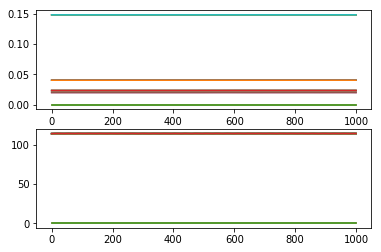

In [23]:
from matplotlib.pyplot import subplots
%matplotlib inline

fig, axs = subplots(2)

for ii in range(4):
    axs[0].plot(a[:, ii])
    axs[1].plot(E[:, ii] / kB)